Task10. Replace the first layer of the network with a 2D convolutional layer. You will need to reshape the USPS images
back to their original 16 by 16 format. Filters of size 5 by 5 are a common choice.

In Python, we use `scipy.signal.convolve2d` to perform 2D convolution, similar to `conv2` in MATLAB.

In [14]:
import numpy as np
from scipy.io import loadmat


def standardizeCols(M, mu=None, sigma2=None):
    M = M.astype(float)  # Ensure M is float for precision
    nrows, ncols = M.shape
    if mu is None or sigma2 is None:
        mu = np.mean(M, axis=0)
        sigma2 = np.std(M, axis=0)
        sigma2[sigma2 < np.finfo(float).eps] = 1  # Avoid division by zero
    S = M - mu  # Subtract mean
    if ncols > 0:
        S = S / sigma2  # Divide by standard deviation
    return S, mu, sigma2


def form_weights(w, offset, nVars, nHidden, nLabels):
    inputWeights = w[offset : offset + nVars *
                     nHidden[0]].reshape(nVars, nHidden[0])
    offset += nVars * nHidden[0]
    hiddenWeights = []
    for h in range(1, len(nHidden)):
        size = nHidden[h-1] * nHidden[h]
        hiddenWeights.append(
            w[offset:offset+size].reshape(nHidden[h-1], nHidden[h]))
        offset += size
    outputWeights = w[offset:offset + nHidden[-1]
                      * nLabels].reshape(nHidden[-1], nLabels)
    return inputWeights, hiddenWeights, outputWeights


def sech2(x):
    return 1 - np.tanh(x)**2

In [16]:
from scipy.signal import convolve2d, correlate2d


def MLPclassificationPredict(w, X, nHidden, nLabels, filterSize):
    nInstances = X.shape[0]
    X = X.reshape(nInstances, 16, 16)
    # form weights
    conv_filter = w[:filterSize**2].reshape(filterSize, filterSize)
    # Apply convolution to each image
    convolved_images = np.array(
        [convolve2d(X[i], conv_filter, mode='valid') for i in range(nInstances)])

    # Flatten the convolved images for feeding into the FC layers
    activations = convolved_images.reshape(nInstances, -1)
    
    offset = filterSize**2
    inputWeights, hiddenWeights, outputWeights = form_weights(w, offset, activations.shape[1], nHidden, nLabels) 
    # Forward pass through the fully connected layers
    for h in range(len(nHidden)):
        activations = np.tanh(activations @ (inputWeights if h == 0 else hiddenWeights[h-1]))
    y = activations @ outputWeights
    y = np.argmax(y, axis=1, keepdims=True) + 1
    return y


def MLPclassificationLoss(w, X, y, nHidden, nLabels, reg_lambda, filterSize):
    nInstances = X.shape[0]
    X = X.reshape(nInstances, 16, 16)

    # Convolution layer weights and convolution
    conv_filter = w[:filterSize**2].reshape(filterSize, filterSize)
    convolved_images = np.array([convolve2d(X[i], conv_filter, mode='valid') for i in range(nInstances)])
    X_conved = convolved_images.reshape(nInstances, -1)

    # Weight extraction adjusted for offset from convolution filter
    offset = filterSize**2
    inputWeights, hiddenWeights, outputWeights = form_weights(
        w, offset, X_conved.shape[1], nHidden, nLabels)
    
    activations = [X_conved]
    for h in range(len(nHidden)):
        z = activations[-1] @ (inputWeights if h == 0 else hiddenWeights[h-1])
        a = np.tanh(z)
        activations.append(a)
    yhat = activations[-1] @ outputWeights

    reg_loss = (reg_lambda / 2) * np.sum(w**2)
    total_loss = 1/2 * np.sum((yhat - y)**2) + reg_loss

    gOutput = activations[-1].T @ (yhat - y) + reg_lambda * outputWeights
    gHidden = []
    delta = (yhat - y) @ outputWeights.T * sech2(activations[-1])
    for h in range(len(nHidden) - 1, 0, -1):
        gHidden.append(activations[h].T @ delta +
                       reg_lambda * hiddenWeights[h-1])
        delta = (delta @ hiddenWeights[h-1].T) * sech2(activations[h])
    gHidden.append(activations[0].T @ delta + reg_lambda * inputWeights)
    gHidden.reverse()
    
    # Gradient for the convolution filter
    size = 16 - filterSize + 1
    # Gradient for the convolution filter
    gConv = np.zeros_like(conv_filter)
    delta = delta @ inputWeights.T  # propagate back to the convolution layer output
    # reshape to the size of the convolved image
    delta = delta.reshape(nInstances, size, size)
    for i in range(nInstances):
        gConv += correlate2d(X[i], delta[i], mode='valid')
    gConv += reg_lambda * conv_filter  # regularization

    # Save gradients
    gradients = [gConv.flatten()]
    for g in gHidden:
        gradients.append(g.flatten())
    gradients.append(gOutput.flatten())
    g = np.concatenate(gradients)

    return total_loss, g.reshape(-1, 1)

Training iteration = 10000, training error = 0.313600, validation error = 0.320800
Training iteration = 20000, training error = 0.345800, validation error = 0.369800
Training iteration = 30000, training error = 0.267200, validation error = 0.273200
Training iteration = 40000, training error = 0.271000, validation error = 0.284600
Training iteration = 50000, training error = 0.260600, validation error = 0.273800
Training iteration = 60000, training error = 0.243800, validation error = 0.263000
Training iteration = 70000, training error = 0.234800, validation error = 0.251400
Training iteration = 80000, training error = 0.216000, validation error = 0.226800
Training iteration = 90000, training error = 0.202000, validation error = 0.214000
Training iteration = 100000, training error = 0.190200, validation error = 0.210400


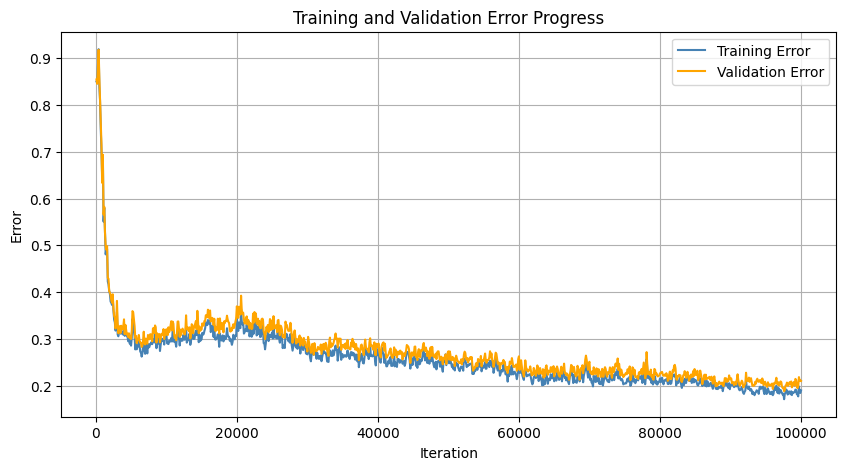

Test error with final model = 0.190000


In [17]:
import matplotlib.pyplot as plt


data = loadmat('digits.mat')
X = data['X']
y = data['y'].flatten()
yvalid = data['yvalid']
ytest = data['ytest']
n, d = X.shape  # 5000, 256
nLabels = np.max(y)  # 10
yExpanded = 2 * np.eye(nLabels)[y - 1] - 1  # turn into one-hot vector
t = data['Xvalid'].shape[0]  # 5000
t2 = data['Xtest'].shape[0]  # 1000
X, mu, sigma = standardizeCols(X)
Xvalid, _, _ = standardizeCols(data['Xvalid'], mu, sigma)
Xtest, _, _ = standardizeCols(data['Xtest'], mu, sigma)

nHidden = [50]

filterSize = 5
nParams =  filterSize**2 + nHidden[0] * (16 - filterSize + 1)**2
nParams += sum(nHidden[h-1] * nHidden[h] for h in range(1, len(nHidden)))
nParams += nHidden[-1] * nLabels
maxIter = 100000
initialStepSize = 1e-4
decayRate = 1e-5
momentum = 0.9
reg_lambda = 0.1


w = np.random.randn(nParams, 1)
w_diff = np.zeros_like(w)
best_w = np.copy(w)
best_validation_error = float('inf')

train_errors = []
valid_errors = []
iterations = []

for iter in range(0, maxIter):
    stepSize = initialStepSize * (1 / (1 + decayRate * iter))
    if (iter + 1) % (maxIter // 1000) == 0:
        yhat1 = MLPclassificationPredict(w, X, nHidden, nLabels, filterSize)
        train_error = np.mean(yhat1 != y.reshape(-1, 1))
        yhat = MLPclassificationPredict(
            w, Xvalid, nHidden, nLabels, filterSize)
        validation_error = np.mean(yhat != yvalid)
        train_errors.append(train_error)
        valid_errors.append(validation_error)
        iterations.append(iter + 1)
        if (iter + 1) % (maxIter // 10) == 0:
            print(f'Training iteration = {iter + 1}, training error = {train_error:.6f}, validation error = {validation_error:.6f}')

        if validation_error < best_validation_error:
            best_validation_error = validation_error
            best_w = np.copy(w)

    i = np.random.randint(n)
    _, g = MLPclassificationLoss(
        w, X[i:i+1], yExpanded[i:i+1], nHidden, nLabels, reg_lambda, filterSize)
    w_diff = momentum * w_diff - stepSize * g
    w += w_diff

# Plot training and validation error progress
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_errors, label='Training Error', color='steelblue')
plt.plot(iterations, valid_errors, label='Validation Error', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Training and Validation Error Progress')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate test error
yhat = MLPclassificationPredict(best_w, Xtest, nHidden, nLabels, filterSize)
test_error = np.mean(yhat != ytest)
print(f'Test error with final model = {test_error:.6f}')